# Figure 3
Assuming operation on google colab

In [1]:
# prepare environment
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# prepare environment
!pip install pycombat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# prepare environment
base_dir = "/content/drive/{YOUR PATH}"

import os
os.chdir(base_dir)

In [4]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

from src import difference as diff

In [12]:
# for Figure 3
def data_prep(batch1,data1,batch2,data2,output,condition):
    """ prep data for figure 3 """
    res_ea = diff.to_response_qc(
        'madz',data1,batch1,key_compound='cmap_name',
        vehicle_control=False,control_names=['DMSO','medium'],drop_control=False,
        intra_batch=True,key_batch='batch_id',spearman=False,out_dir=output,name='f3_EA',qc=condition
    )
    res_a = diff.to_response_qc(
        'madz',data2,batch2,key_compound='cmap_name',
        vehicle_control=False,control_names=['DMSO','medium'],drop_control=False,
        intra_batch=True,key_batch='batch_id',spearman=False,out_dir=output,name='f3_A',qc=condition
    )

    ea_ser = pd.DataFrame(pd.Series(res_ea[1]))
    a_ser = pd.DataFrame(pd.Series(res_a[1]))
    res_thresh = pd.concat([ea_ser,a_ser],axis=1,join='inner')
    res_thresh.columns = ['HT-HG-U133A_EA','HT-HG-U133A']
    res_thresh.to_csv(output + '/f3_threshold.csv')


def calc_dc(batch1,data1,batch2,data2,output,condition):
    """ calculate intraDC and interDC """
    res_a = []
    res_ea = []
    nega_a = dict()
    nega_ea = dict()
    result = []
    negative = dict()
    for q in condition:
        temp = str(q).replace('.','')
        a = pd.read_pickle(output + '/grp_f3_A_{}.pkl'.format(temp))
        ea = pd.read_pickle(output + '/grp_f3_EA_{}.pkl'.format(temp))
        a = a.replace([np.inf,-np.inf],np.nan)
        ea = ea.replace([np.inf,-np.inf],np.nan)
        a = a.dropna()
        ea = ea.dropna()
        # A
        r,n = diff.intra_dc(
            'madz',data1,batch1,key_compound='cmap_name',
            vehicle_control=False,control_names=['DMSO','medium'],drop_control=False,
            intra_batch=False,key_batch='batch_id',spearman=False
        )
        r.loc[:,'fold'] = [q] * r.shape[0]
        n = n.values.ravel()
        res_a.append(r)
        nega_a[q] = n
        # EA
        r,n = diff.intra_dc(
            'madz',data2,batch2,key_compound='cmap_name',
            vehicle_control=False,control_names=['DMSO','medium'],drop_control=False,
            intra_batch=False,key_batch='batch_id',spearman=False
        )
        r.loc[:,'fold'] = [q] * r.shape[0]
        n = n.values.ravel()
        res_ea.append(r)
        nega_ea[q] = n
        # interDC
        r,n = diff.inter_dc(a,ea,output + '/f3_interDC_{}.csv'.format(temp))
        r.loc[:,'fold'] = [q] * r.shape[0]
        n = n.values.ravel()
        result.append(r)
        negative[q] = n
    res_a2 = pd.concat(res_a,axis=0,join='inner')
    nega_a2 = np.concatenate(list(nega_a.values()))
    res_ea2 = pd.concat(res_ea,axis=0,join='inner')
    nega_ea2 = np.concatenate(list(nega_ea.values()))
    result2 = pd.concat(result,axis=0,join='inner')
    negative2 = np.concatenate(list(negative.values()))
    return (res_a,nega_a),(res_ea,nega_ea),(result,negative),(res_a2,nega_a2),(res_ea2,nega_ea2),(result2,negative2)


def plot_result(result,negative,result2,negative2,out_ks,condition,name='intraDC',color='darkgoldenrod'):
    """ plot results """
    # plot
    n_sample = len(condition)
    fig,axes = plt.subplots(n_sample,1,squeeze=False,tight_layout=True,figsize=(6,3*n_sample))
    plt.rcParams['font.size'] = 14
    ks_res = []
    imax = np.max(result2[name])
    imin = np.min(result2[name])
    nmax = np.max(negative2)
    nmin = np.min(negative2)
    vmax = np.max([imax,nmax])
    vmin = np.min([imin,nmin])
    count = 0
    for r,n,t in zip(result,list(negative.values()),condition):
        b = r[name].values.ravel()
        sns.distplot(n,ax=axes[count,0],hist=False,label='null',color='grey')
        sns.distplot(b,ax=axes[count,0],hist=False,label=name,color=color)
        axes[count,0].set_title(t)
        axes[count,0].spines['top'].set_visible(False)
        axes[count,0].spines['right'].set_visible(False)
        axes[count,0].set_xlim((vmin - np.abs(vmax) * 0.1,vmax + np.abs(vmax) * 0.1))
        ks_res.append(stats.ks_2samp(n,b))
        print(ks_res[-1])
        count += 1
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    ks_res2 = pd.DataFrame(ks_res,index=condition)
    print(ks_res2)
    ks_res2.to_csv(out_ks)


def main(batch1,data1,batch2,data2,output,condition):
    data_prep(batch1,data1,batch2,data2,output,condition)
    results = calc_dc(batch1,data1,batch2,data2,output,condition)
    # intraDC, A
    plot_result(
        results[0][0],results[0][1],results[3][0],results[3][1],output + '/fig3_ks_intraDC_A.csv',
        condition,'intraDC','darkgoldenrod'
        )
    # intraDC, EA
    plot_result(
        results[1][0],results[1][1],results[4][0],results[4][1],output + '/fig3_ks_intraDC_EA.csv',
        condition,'intraDC','darkgoldenrod'
        )
    # interDC
    plot_result(
        results[2][0],results[2][1],results[5][0],results[5][1],output + '/fig3_ks_interDC.csv',
        condition,'interDC','royalblue'
        )


def main2(batch1,data1,batch2,data2,output,condition):
    results = calc_dc(batch1,data1,batch2,data2,output,condition)
    # intraDC, A
    plot_result(
        results[0][0],results[0][1],results[3][0],results[3][1],output + '/fig3_ks_intraDC_A.csv',
        condition,'intraDC','darkgoldenrod'
        )
    # intraDC, EA
    plot_result(
        results[1][0],results[1][1],results[4][0],results[4][1],output + '/fig3_ks_intraDC_EA.csv',
        condition,'intraDC','darkgoldenrod'
        )
    # interDC
    plot_result(
        results[2][0],results[2][1],results[5][0],results[5][1],output + '/fig3_ks_interDC.csv',
        condition,'interDC','darkroyalblue'
        )

100%|██████████| 49/49 [00:00<00:00, 377.25it/s]


0.5
(49, 1)
(45, 1)
1.0
(49, 1)
(37, 1)
1.5
(49, 1)
(29, 1)
2.0
(49, 1)
(24, 1)
2.5
(49, 1)
(22, 1)
3.0
(49, 1)
(19, 1)


100%|██████████| 1074/1074 [00:04<00:00, 230.53it/s]


0.5
(1074, 1)
(670, 1)
1.0
(1074, 1)
(505, 1)
1.5
(1074, 1)
(369, 1)
2.0
(1074, 1)
(280, 1)
2.5
(1074, 1)
(229, 1)
3.0
(1074, 1)
(193, 1)


100%|██████████| 1074/1074 [00:04<00:00, 225.48it/s]
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level fu

KstestResult(statistic=0.7391581632653061, pvalue=9.992007221626409e-16)
KstestResult(statistic=0.7391581632653061, pvalue=9.992007221626409e-16)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

KstestResult(statistic=0.7391581632653061, pvalue=9.992007221626409e-16)
KstestResult(statistic=0.7391581632653061, pvalue=9.992007221626409e-16)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

KstestResult(statistic=0.7391581632653061, pvalue=9.992007221626409e-16)
KstestResult(statistic=0.7391581632653061, pvalue=9.992007221626409e-16)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


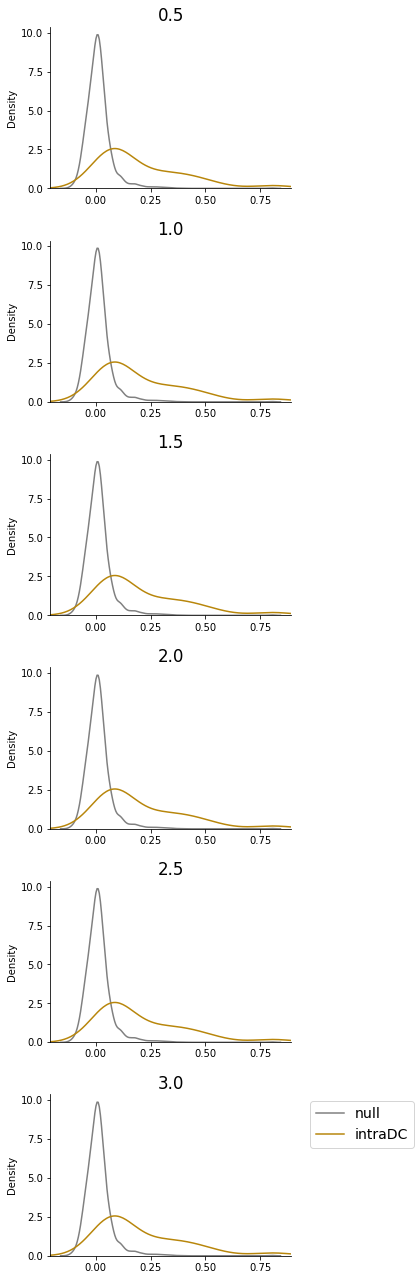

     statistic        pvalue
0.5   0.739158  9.992007e-16
1.0   0.739158  9.992007e-16
1.5   0.739158  9.992007e-16
2.0   0.739158  9.992007e-16
2.5   0.739158  9.992007e-16
3.0   0.739158  9.992007e-16


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


KstestResult(statistic=0.3864558548145526, pvalue=9.821598986046698e-145)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


KstestResult(statistic=0.3864558548145526, pvalue=9.821598986046698e-145)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


KstestResult(statistic=0.3864558548145526, pvalue=9.821598986046698e-145)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


KstestResult(statistic=0.3864558548145526, pvalue=9.821598986046698e-145)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


KstestResult(statistic=0.3864558548145526, pvalue=9.821598986046698e-145)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


KstestResult(statistic=0.3864558548145526, pvalue=9.821598986046698e-145)


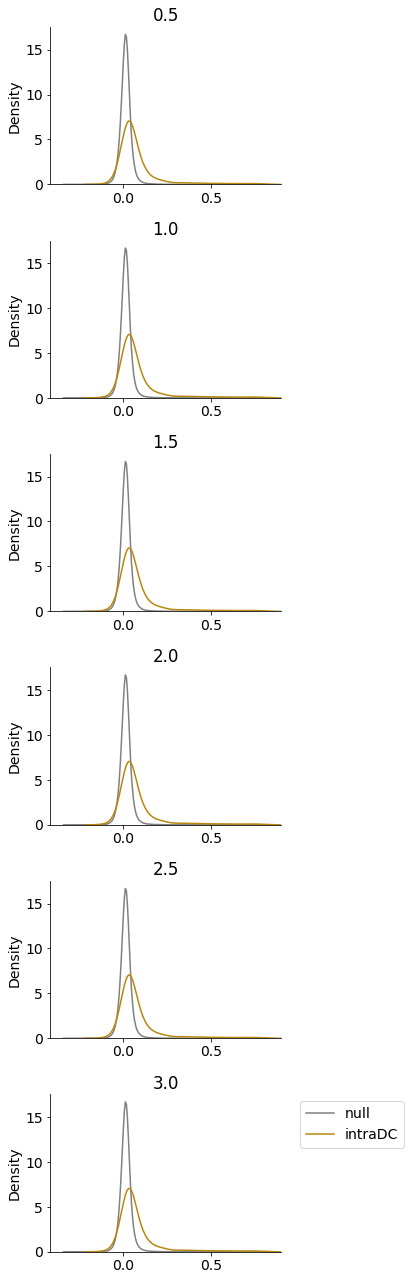

     statistic         pvalue
0.5   0.386456  9.821599e-145
1.0   0.386456  9.821599e-145
1.5   0.386456  9.821599e-145
2.0   0.386456  9.821599e-145
2.5   0.386456  9.821599e-145
3.0   0.386456  9.821599e-145


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

KstestResult(statistic=0.8009083592043234, pvalue=1.831238409288653e-18)
KstestResult(statistic=0.8044444444444444, pvalue=5.566482359902218e-18)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

KstestResult(statistic=0.8432494279176201, pvalue=2.220446049250313e-15)
KstestResult(statistic=0.868437697659709, pvalue=5.551115123125783e-16)
KstestResult(statistic=0.9163925438596491, pvalue=4.440892098500626e-16)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

KstestResult(statistic=0.9791666666666666, pvalue=5.803001360792764e-24)


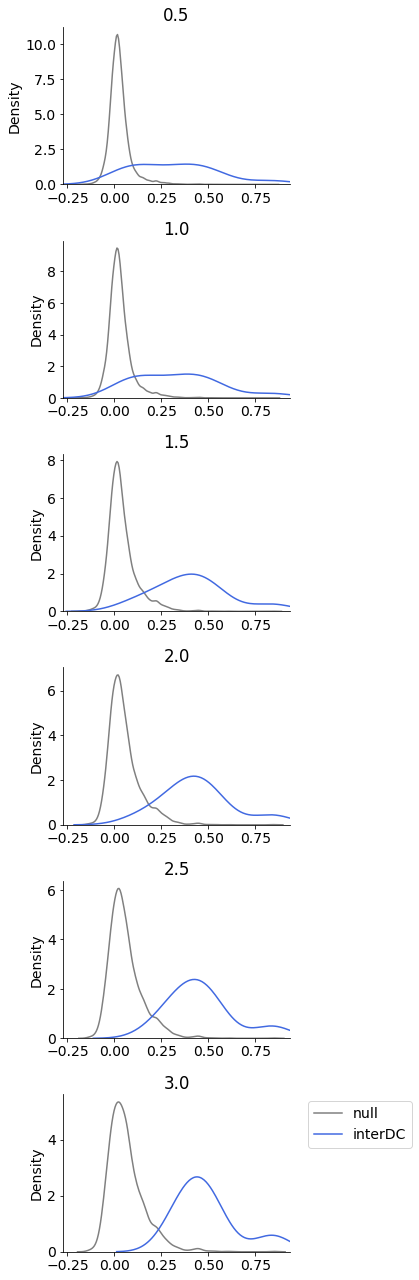

     statistic        pvalue
0.5   0.800908  1.831238e-18
1.0   0.804444  5.566482e-18
1.5   0.843249  2.220446e-15
2.0   0.868438  5.551115e-16
2.5   0.916393  4.440892e-16
3.0   0.979167  5.803001e-24


In [13]:
# Figure 3
# the impact on interDC by introducing the threshold based on intraDC
batch1 = pd.read_csv(base_dir + "/data/batch_HT-HG-U133A_EA_selected.txt", sep='\t', index_col=0)
data1 = pd.read_pickle(base_dir + "/data/HTHGU133AEA_done_qn.pkl")
batch2 = pd.read_csv(base_dir + "/data/batch_HT-HG-U133A_selected.txt", sep='\t', index_col=0)
data2 = pd.read_pickle(base_dir + "/data/HTHGU133A_done_qn.pkl")
output = base_dir + "/output/Fig3"

condition = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

main(batch1, data1, batch2, data2, output, condition)

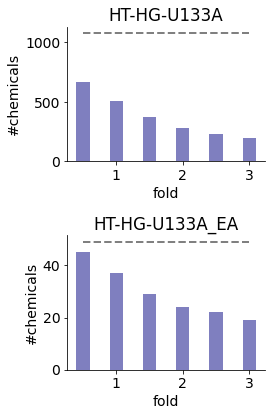

In [14]:
# Figure 3
# the impact on the number of available samples after introducing the threshold based on intraDC

figsize = (4,6)
color = 'navy'
alpha = 0.5
width = 0.2
condition = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
output = base_dir + "/output/Fig3"

nA = pd.read_pickle(base_dir + '/output/Fig2/grp_large.pkl').shape[1]
nEA = pd.read_pickle(base_dir + '/output/Fig2/grp_all_in_whole.pkl').shape[1]

l = glob.glob(output + '/*.pkl')
l_A = [v for v in l if 'f3_A' in v]
l_EA = [v for v in l if 'f3_EA' in v]
d_A = [pd.read_pickle(v).shape[1] for v in l_A]
d_EA = [pd.read_pickle(v).shape[1] for v in l_EA]

fig,axes = plt.subplots(2,1,squeeze=False,tight_layout=True,figsize=figsize)
plt.rcParams['font.size'] = 14

axes[0,0].bar(condition,d_A,color=color,alpha=alpha,width=width)
axes[0,0].hlines(nA,0.5,3.0,color='grey',linestyle='dashed',linewidth=2)
axes[0,0].set_title('HT-HG-U133A')
axes[0,0].spines['top'].set_visible(False)
axes[0,0].spines['right'].set_visible(False)
axes[0,0].set_ylabel('#chemicals')
axes[0,0].set_xlabel('fold')
axes[1,0].bar(condition,d_EA,color=color,alpha=alpha,width=width)
axes[1,0].hlines(nEA,0.5,3.0,color='grey',linestyle='dashed',linewidth=2)
axes[1,0].set_title('HT-HG-U133A_EA')
axes[1,0].spines['top'].set_visible(False)
axes[1,0].spines['right'].set_visible(False)
axes[1,0].set_ylabel('#chemicals')
axes[1,0].set_xlabel('fold')

plt.show()

--- A ---


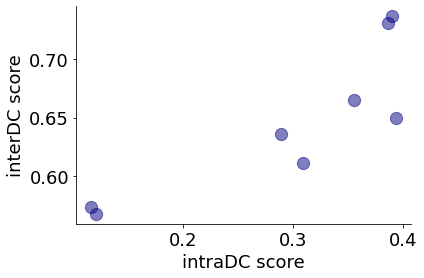

--- EA ---


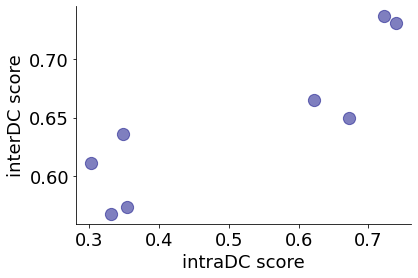

In [41]:
# Supplementary Figure 3
# investigation of the relationship between intraDC and interDC
class InterIntra:
    def __init__(self):
        self.ds_a = dict() # key:(inter, intra_a)
        self.ds_ea = dict() # key:(inter, intra_ea)

    def add_data(self, f_inter, f_intra, ds):
        """ load data for analysis """
        inter = pd.read_csv(f_inter, index_col=0)
        intra = pd.read_csv(f_intra, index_col=0)
        if ds=="a":
            n = len(self.ds_a) + 1
            self.ds_a[n] = (inter, intra)
        elif ds=="ea":
            n = len(self.ds_a) + 1
            self.ds_ea[n] = (inter, intra)

    def calc_corr(self):
        """ calculate correlation and visualize it """
        # A
        print("--- A ---")
        self._calc_corr(self.ds_a)
        # EA
        print("--- EA ---")
        self._calc_corr(self.ds_ea)

    def _calc_corr(self, ds):
        """ calculate correlation and visualize it """
        # calculate corr
        comb_inter = []
        comb_intra = []
        for k, v in ds.items():
            tmp1 = v[0].sort_index()
            tmp1 = list(tmp1["statistic"])
            tmp2 = v[1].sort_index()
            tmp2 = list(tmp2["statistic"])
            comb_inter[len(comb_inter):] = tmp1
            comb_intra[len(comb_intra):] = tmp2
        comb = np.array([comb_inter, comb_intra])
        corr = np.corrcoef(comb)

        # visualize them
        plt.figure()
        plt.rcParams["font.size"] = 18
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.scatter(comb[1], comb[0], color="navy", alpha=0.5, s=150)
        plt.xlabel("intraDC score")
        plt.ylabel("interDC score")
        plt.show()

dat = InterIntra()
out_dir = base_dir + "/output"

# fig 1 & 2
dat.add_data(out_dir + "/Fig2/ks_res.csv", out_dir + "/Fig1/ks_res_EA.csv", "ea")
dat.add_data(out_dir + "/Fig2/ks_res.csv", out_dir + "/SFig2/ks_res.csv", "a")
dat.add_data(out_dir + "/Fig2/ks_res_noBC.csv", out_dir + "/Fig1/ks_res_noBC_EA.csv", "ea")
dat.add_data(out_dir + "/Fig2/ks_res_noBC.csv", out_dir + "/SFig2/ks_res_noBC.csv", "a")
# visualization
dat.calc_corr()